# Item-to-Item Product Recommendation by Collaborative Filtering

Data source: Online Retail Data Set from UCI Machine Learning Repository (http://archive.ics.uci.edu/ml/datasets/online+retail)

**Load & Prepare the Data**

In [1]:
# Import necessary libraries.
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Read data source Excel files.
df1 = pd.read_excel('./data/Online Retail.xlsx')

In [3]:
# Check dataframe information.
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
# Read header of dataframe.
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# Check any column containing the null value.
df1.isnull().any()

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

In [6]:
# Count the number of null value records in the CustomerID column.
df1['CustomerID'].isna().sum()

135080

In [7]:
df1a = df1.dropna(subset=['CustomerID'])

In [8]:
# Check dataframe information.
df1a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [9]:
# Read header of dataframe.
df1a.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
# Create CustomerID vs Item (Purchased Items, by StockCode) matrix by pivot table function.
CustomerID_Item_matrix = df1a.pivot_table(
    index='CustomerID', 
    columns='StockCode', 
    values='Quantity',
    aggfunc='sum'
)

In [11]:
# Display the shape of matrix, 4372 rows of CustomerID, 3684 columns of Item.
CustomerID_Item_matrix.shape

(4372, 3684)

In [12]:
# Update illustration of the matrix, 1 to represent customer have purchased item, 0 to represent customer haven't purchased.
CustomerID_Item_matrix = CustomerID_Item_matrix.applymap(lambda x: 1 if x > 0 else 0)

In [13]:
# Read header of CustomerID vs Item matrix.
CustomerID_Item_matrix.loc[12680:].head()

StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214Y,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12680.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12681.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12682.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12683.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12684.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


**Calculate the Item to Item similarity by Cosine Similarity**

In [14]:
# Create Item to Item similarity matrix.
item_item_similarity_matrix = pd.DataFrame(
    cosine_similarity(CustomerID_Item_matrix.T)
)

In [15]:
# Display header of Item to Item similarity matrix. 
item_item_similarity_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,3674,3675,3676,3677,3678,3679,3680,3681,3682,3683
0,1.000000,0.000000,0.094868,0.090351,0.063246,0.098907,0.095346,0.047673,0.076139,0.091050,...,0.0,0.0,0.0,0.029361,0.0,0.0,0.0,0.059423,0.00,0.070057
1,0.000000,1.000000,0.000000,0.032774,0.045883,0.047836,0.000000,0.000000,0.082855,0.049541,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.017244,0.00,0.000000
2,0.094868,0.000000,1.000000,0.057143,0.060000,0.041703,0.060302,0.060302,0.096309,0.028793,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.075165,0.00,0.000000
3,0.090351,0.032774,0.057143,1.000000,0.042857,0.044682,0.043073,0.000000,0.051594,0.030849,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.075165,0.00,0.071209
4,0.063246,0.045883,0.060000,0.042857,1.000000,0.281494,0.045227,0.060302,0.072232,0.057585,...,0.0,0.0,0.0,0.037139,0.0,0.0,0.0,0.067648,0.05,0.016615


In [16]:
# Update index to corresponding Item Code (StockCode).
item_item_similarity_matrix.columns = CustomerID_Item_matrix.T.index
item_item_similarity_matrix['StockCode'] = CustomerID_Item_matrix.T.index
item_item_similarity_matrix = item_item_similarity_matrix.set_index('StockCode')

In [17]:
# Display header of Item to Item similarity matrix. 
item_item_similarity_matrix.head()

StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214Y,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,1.000000,0.000000,0.094868,0.090351,0.063246,0.098907,0.095346,0.047673,0.076139,0.091050,...,0.0,0.0,0.0,0.029361,0.0,0.0,0.0,0.059423,0.00,0.070057
10080,0.000000,1.000000,0.000000,0.032774,0.045883,0.047836,0.000000,0.000000,0.082855,0.049541,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.017244,0.00,0.000000
10120,0.094868,0.000000,1.000000,0.057143,0.060000,0.041703,0.060302,0.060302,0.096309,0.028793,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.075165,0.00,0.000000
10125,0.090351,0.032774,0.057143,1.000000,0.042857,0.044682,0.043073,0.000000,0.051594,0.030849,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.075165,0.00,0.071209
10133,0.063246,0.045883,0.060000,0.042857,1.000000,0.281494,0.045227,0.060302,0.072232,0.057585,...,0.0,0.0,0.0,0.037139,0.0,0.0,0.0,0.067648,0.05,0.016615


In [19]:
# Randomly pick StockCode (23166) to display the most similar StockCode.
top_10_similar_items = list(
    item_item_similarity_matrix\
        .loc[23166]\
        .sort_values(ascending=False)\
        .iloc[:10]\
    .index
)

In [20]:
# Display top 10 similar items of StockCode (23166).
top_10_similar_items

[23166, 23165, 23167, 22993, 23307, 22722, 23243, 22666, 22720, 22961]

In [25]:
# Display the list of similar items of StockCode (23166) with item Description.
df1a.loc[
    df1a['StockCode'].isin(top_10_similar_items), 
    ['StockCode', 'Description']
].drop_duplicates().set_index('StockCode').loc[top_10_similar_items]

,Description
StockCode,
23166,MEDIUM CERAMIC TOP STORAGE JAR
23165,LARGE CERAMIC TOP STORAGE JAR
23167,SMALL CERAMIC TOP STORAGE JAR
22993,SET OF 4 PANTRY JELLY MOULDS
23307,SET OF 60 PANTRY DESIGN CAKE CASES
22722,SET OF 6 SPICE TINS PANTRY DESIGN
23243,SET OF TEA COFFEE SUGAR TINS PANTRY
22666,RECIPE BOX PANTRY YELLOW DESIGN
22720,SET OF 3 CAKE TINS PANTRY DESIGN


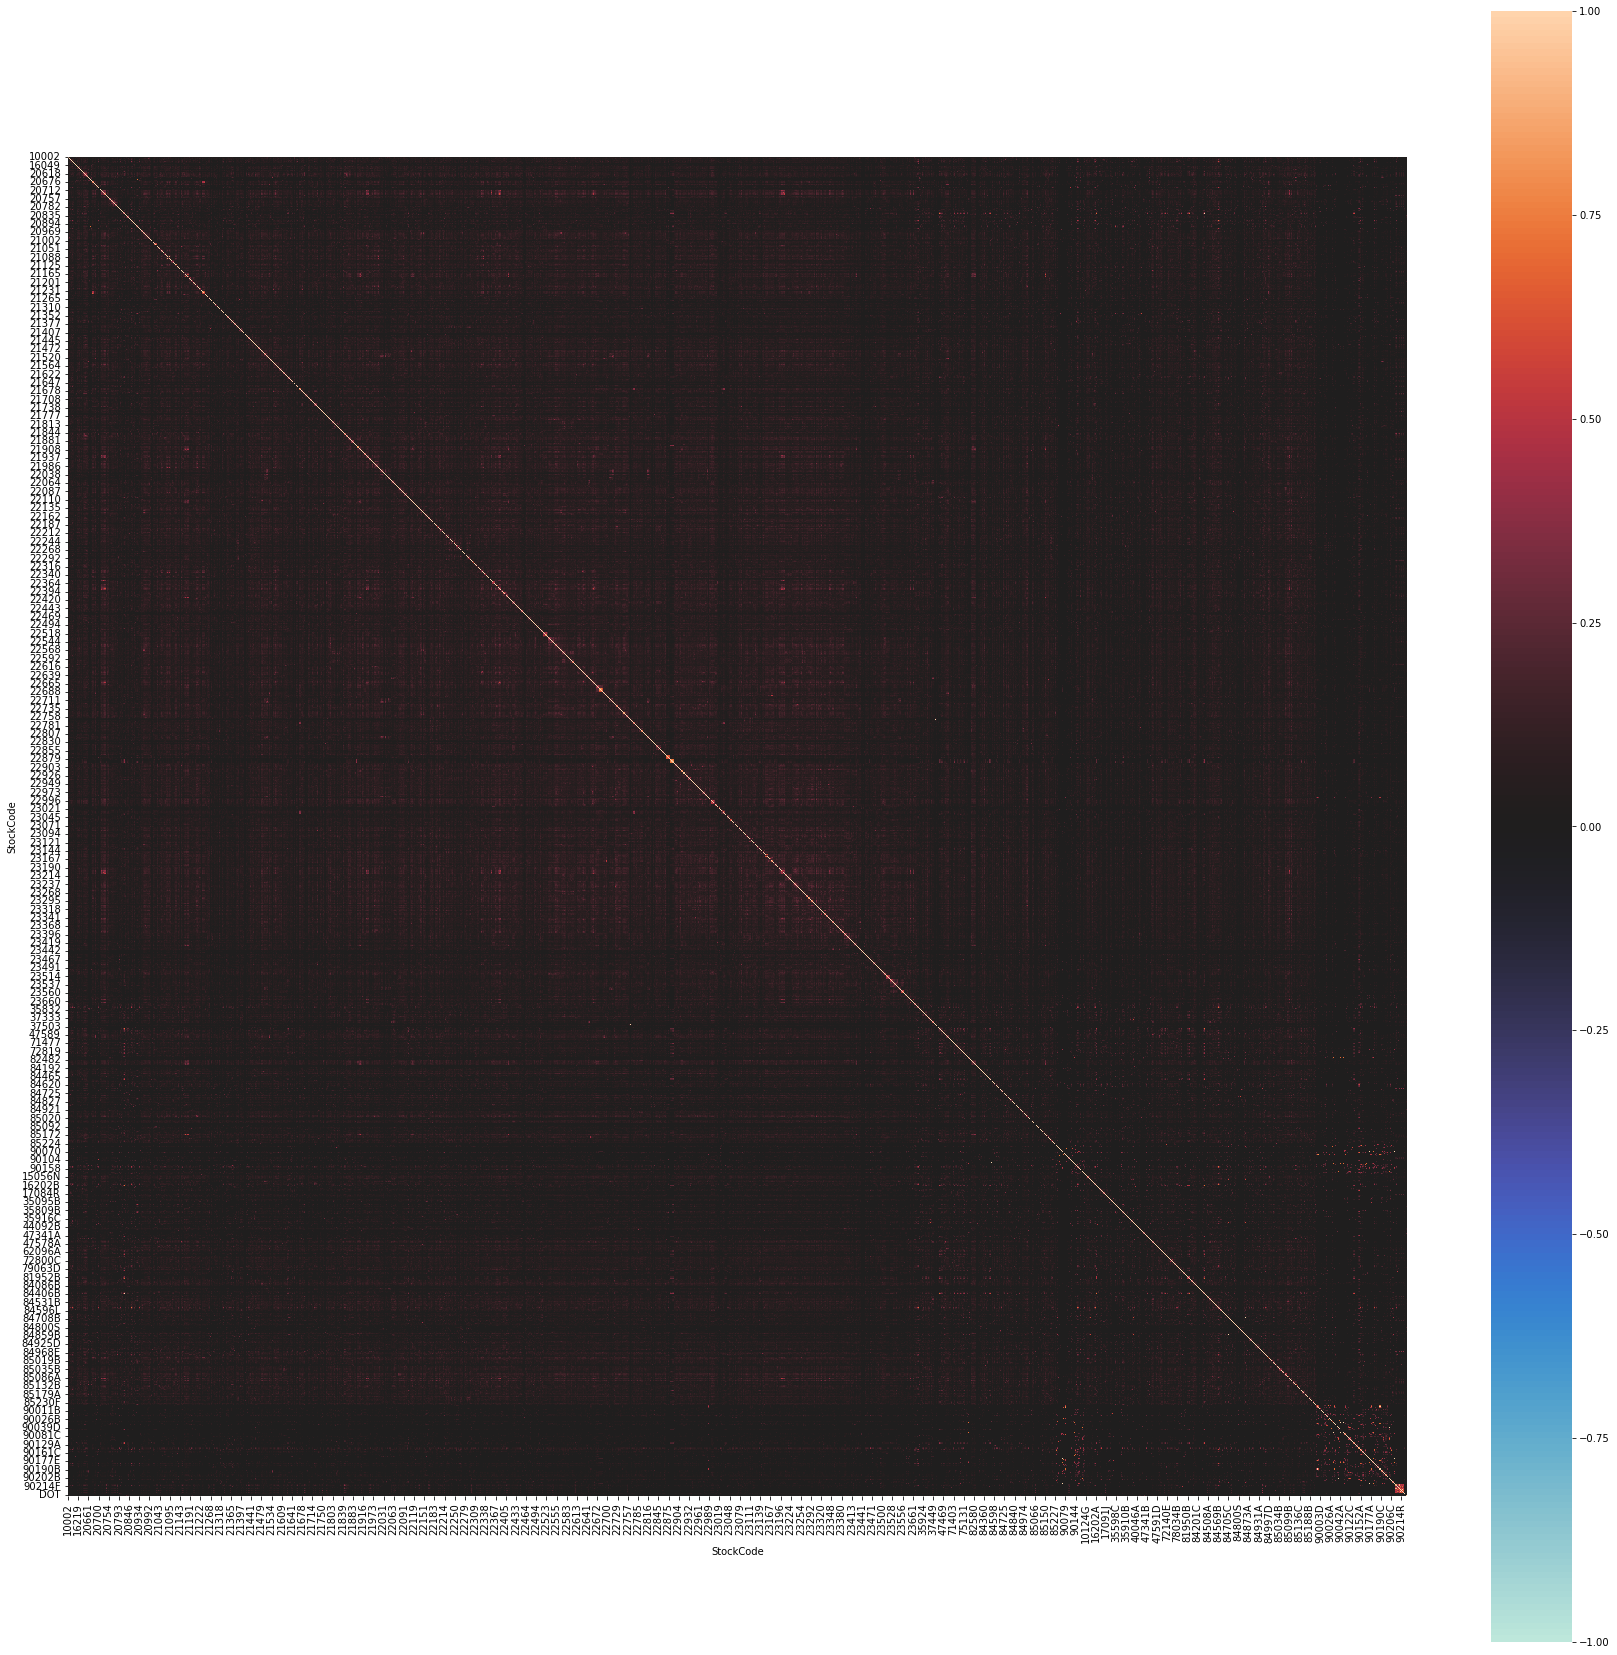

In [26]:
# And optionally, use the heatmap to display the Item to Item similarity matrix.
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (30,30))
ax = sns.heatmap(
    item_item_similarity_matrix, 
    vmin=-1, vmax=1, center=0,
    square=True)